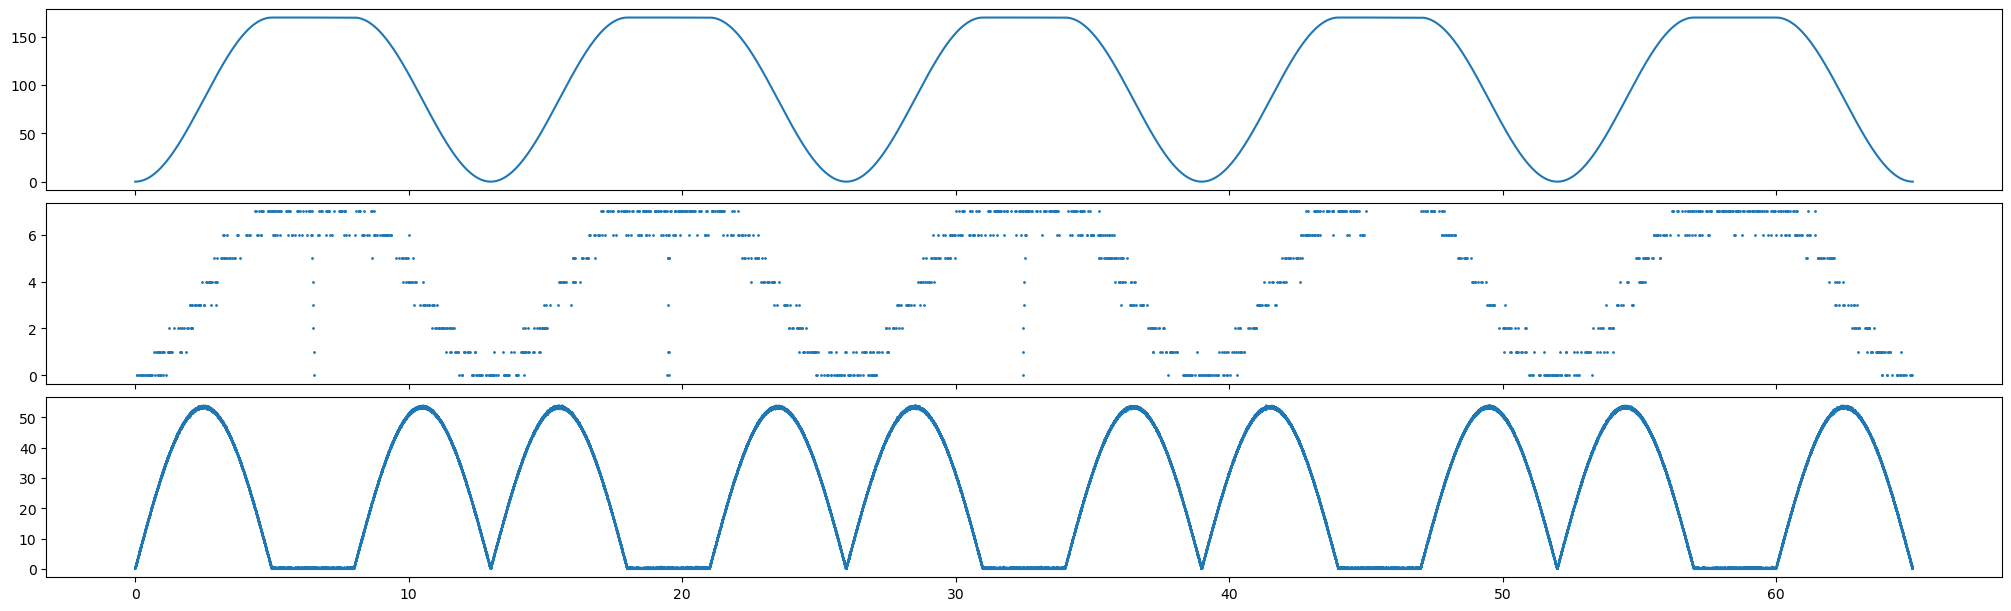

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

is_ripple = np.zeros_like(time, dtype=bool)
for ripple_time in ripple_times:
    is_ripple |= (time >= ripple_time[0]) & (time <= ripple_time[1])


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 6))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)

In [2]:
from replay_trajectory_classification import Environment

env = Environment(place_bin_size=2.0).fit_place_grid(position[:, None])


Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


In [3]:
speed_knots = [0.5, 4.0, 20.0]


In [4]:
from src.test_non_local_switching_non_stationary_model import (
    setup_nonlocal_switching_model,
)

(
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    speed,
    env,
    sampling_frequency=sampling_frequency,
    speed_knots=speed_knots,
    is_stationary_discrete_transition=True,
    include_no_spike_state=True,
    rw_movement_var=30.0,
)


In [5]:
discrete_state_transitions.shape

(4, 4)

In [6]:
discrete_state_transitions.sum(axis=-1)

array([1., 1., 1., 1.])

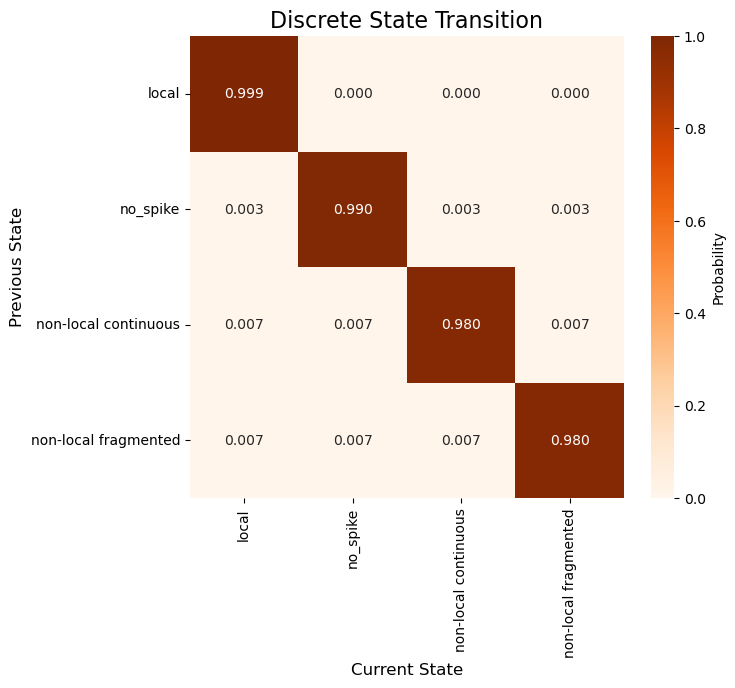

In [7]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward
import seaborn as sns


if discrete_transition_design_matrix is not None:
    predict_data = {"speed": np.arange(0, 50.0)}
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]


    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

    for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
        from_local_transition = centered_softmax_forward(
            predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
        )

        ax.plot(predict_data["speed"], from_local_transition)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Prob.")
        ax.legend(state_names)
        ax.set_title(f"From {from_state}")
        
    plt.ylim((0, 1.01))
else:
    vmin, vmax, fmt = 0.0, 1.0, "0.03f"
    label = "Probability"
    cmap = "Oranges"

    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.heatmap(
        data=discrete_state_transitions,
        vmin=vmin,
        vmax=vmax,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        xticklabels=state_names,
        yticklabels=state_names,
        ax=ax,
        cbar_kws={"label": label},
    )
    ax.set_ylabel("Previous State", fontsize=12)
    ax.set_xlabel("Current State", fontsize=12)
    ax.set_title("Discrete State Transition", fontsize=16)

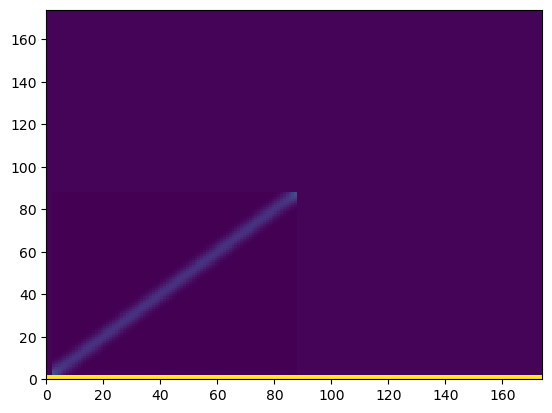

In [8]:
plt.pcolormesh(continuous_state_transitions.T)

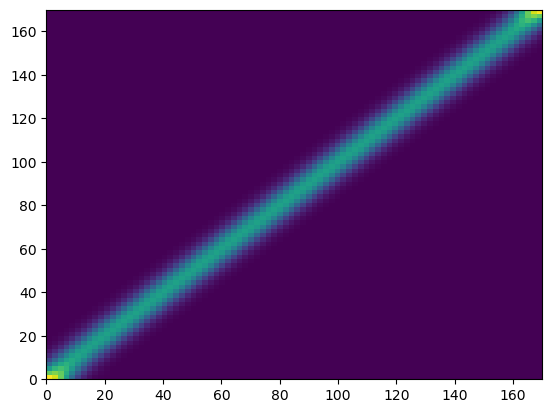

In [9]:
plt.pcolormesh(env.edges_[0], env.edges_[0], continuous_state_transitions[np.ix_(state_ind == 2, state_ind == 2)])

In [10]:
from src.test_non_local_switching_non_stationary_model import fit_switching_model

stickiness = np.array([100.0, 100_000.0, 100.0, 100.0])
(
    predicted_state,
    acausal_posterior,
    acausal_state_probabilities,
    causal_posterior,
    marginal_log_likelihoods,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    non_local_rates,
    log_likelihood,
) = fit_switching_model(
    spikes,
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    env,
    discrete_transition_coefficients=discrete_transition_coefficients,
    discrete_transition_design_matrix=discrete_transition_design_matrix,
    max_iter=100,
    fit_inital_conditions=True,
    fit_discrete_transition=True,
    fit_likelihood=False,
    concentration=1.1,
    stickiness=stickiness,
)


[[9.99000000e-01 3.33333333e-04 3.33333333e-04 3.33333333e-04]
 [3.33333333e-03 9.90000000e-01 3.33333333e-03 3.33333333e-03]
 [6.66666667e-03 6.66666667e-03 9.80000000e-01 6.66666667e-03]
 [6.66666667e-03 6.66666667e-03 6.66666667e-03 9.80000000e-01]]
Likelihoods


  0%|          | 0/8 [00:00<?, ?it/s]

Expectation Step
Maximization Step
Stats
iteration 1, likelihood: -9315.291401343384
[[9.99502363e-01 1.76877998e-04 1.65938897e-04 1.54820575e-04]
 [1.56164247e-04 9.99671897e-01 8.71538828e-05 8.47845465e-05]
 [1.11236035e-02 7.13574812e-03 9.76015051e-01 5.72559747e-03]
 [1.17094491e-02 7.40850988e-03 6.37478748e-03 9.74507254e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 2, likelihood: -9284.337989337733, change: 30.953412005650534
[[9.99809472e-01 1.99287934e-05 9.06248142e-05 7.99745100e-05]
 [1.88990221e-05 9.99970633e-01 5.28304918e-06 5.18472409e-06]
 [1.37302513e-02 1.03952833e-03 9.80815592e-01 4.41462805e-03]
 [1.46847703e-02 1.08354865e-03 5.31859460e-03 9.78913086e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 3, likelihood: -9263.444319942433, change: 20.893669395300094
[[9.99857913e-01 9.29540656e-06 7.28006502e-05 5.99910967e-05]
 [8.75014526e-06 9.99987153e-01 2.04349799e-06 2.05303091e-06]
 [1.16258012e-02 4.12304280e-04 9

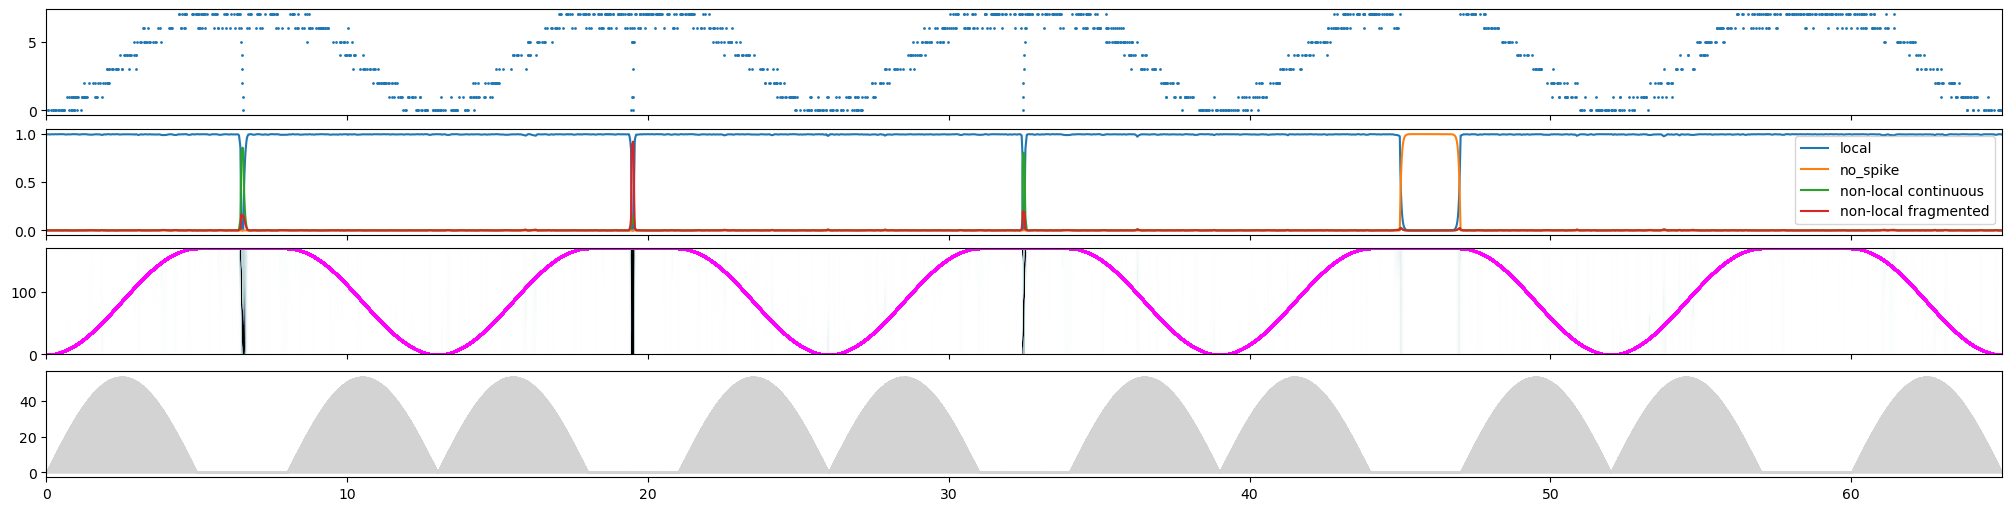

In [11]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(0, len(time)),
    figsize=(20, 5)
)


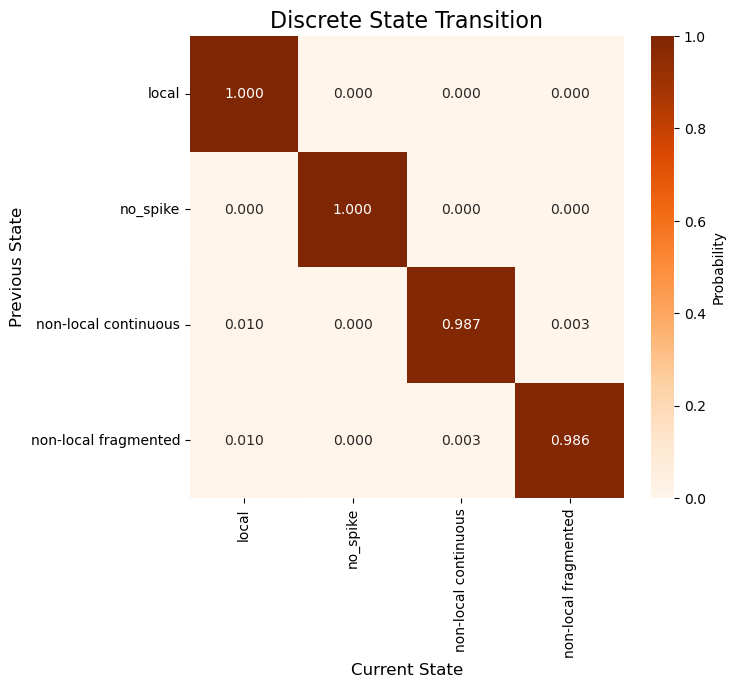

In [12]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward
import seaborn as sns


if discrete_transition_design_matrix is not None:
    predict_data = {"speed": np.arange(0, 50.0)}
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]


    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

    for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
        from_local_transition = centered_softmax_forward(
            predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
        )

        ax.plot(predict_data["speed"], from_local_transition)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Prob.")
        ax.legend(state_names)
        ax.set_title(f"From {from_state}")
        
    plt.ylim((0, 1.01))
else:
    vmin, vmax, fmt = 0.0, 1.0, "0.03f"
    label = "Probability"
    cmap = "Oranges"

    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.heatmap(
        data=discrete_state_transitions,
        vmin=vmin,
        vmax=vmax,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        xticklabels=state_names,
        yticklabels=state_names,
        ax=ax,
        cbar_kws={"label": label},
    )
    ax.set_ylabel("Previous State", fontsize=12)
    ax.set_xlabel("Current State", fontsize=12)
    ax.set_title("Discrete State Transition", fontsize=16)


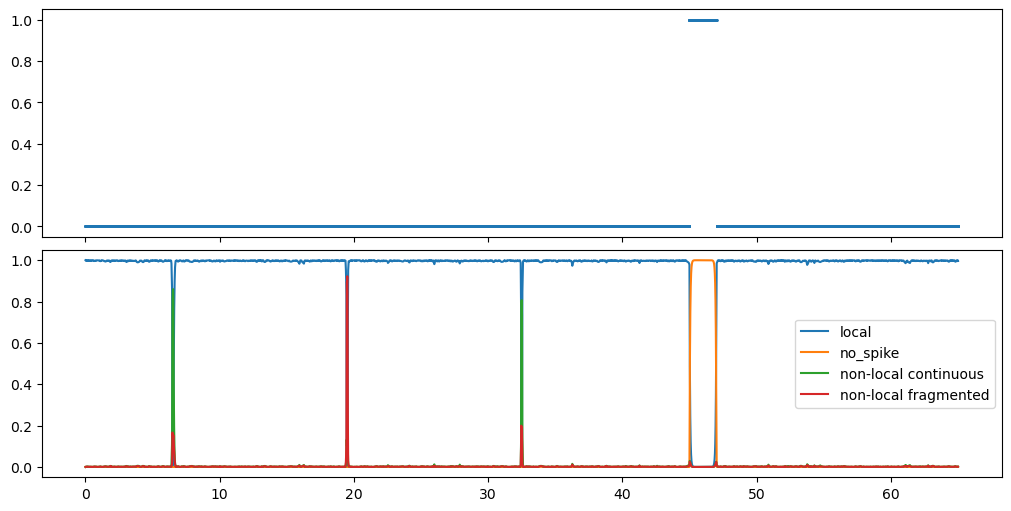

In [29]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))
axes[0].scatter(time, predicted_state, label=state_names, s=1)
axes[1].plot(time, acausal_state_probabilities, label=state_names)
axes[1].legend()